In [1]:
import numpy as np
np.random.seed(42)

In [2]:
n = 10
Q = 20
N = [i for i in range(1, n+1)]
V = [0] + N
q = {i: np.random.randint(1, 10) for i in N}

In [3]:
loc_x = np.random.rand(len(V)) * 200
loc_y = np.random.rand(len(V)) * 200
# Fix the depot at location (100, 100)
loc_x[0] = 100
loc_y[0] = 100

In [4]:
import matplotlib.pyplot as plt

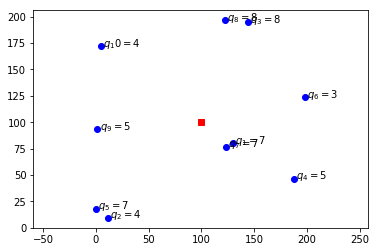

In [5]:
plt.scatter(loc_x[1:], loc_y[1:], c='b')
for i in N:
    plt.annotate('$q_%d=%d$' % (i, q[i]), (loc_x[i]+2, loc_y[i]))
plt.plot(loc_x[0], loc_y[0], c='r', marker='s')
plt.axis('equal');

In [6]:
# Edges
A = [(i, j) for i in V for j in V if i != j]
# Cost (Euclidean distance)
c = {(i, j): np.hypot(loc_x[i] - loc_x[j], loc_y[i] - loc_y[j]) for i, j in A}

In [7]:
from docplex.mp.model import Model

In [8]:
model = Model('CVRP')

In [9]:
# Define variables
x = model.binary_var_dict(A, name = 'x')
u = model.continuous_var_dict(N, ub = Q, name = 'u') # lb = 0 by default

In [10]:
# Objective function
model.minimize(model.sum(c[i, j] * x[i, j] for i, j in A))

In [11]:
# Constraints
model.add_constraints(model.sum(x[i, j] for j in V if j != i) == 1 for i in N)
model.add_constraints(model.sum(x[i, j] for i in V if i != j) == 1 for j in N)
model.add_indicator_constraints(model.indicator_constraint(x[i, j], u[i] + q[j] == u[j]) for i, j in A if i != 0 and j != 0)
model.add_constraints(u[i] >= q[i] for i in N)

# Add a time limit on the solver
model.parameters.timelimit = 20

In [12]:
solution = model.solve(log_output=True)

CPXPARAM_Read_DataCheck                          1
CPXPARAM_TimeLimit                               20
Found incumbent of value 1903.072828 after 0.00 sec. (0.01 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 10 rows and 0 columns.
MIP Presolve modified 45 coefficients.
Aggregator did 45 substitutions.
Reduced MIP has 65 rows, 165 columns, and 335 nonzeros.
Reduced MIP has 110 binaries, 0 generals, 0 SOSs, and 90 indicators.
Presolve time = 0.01 sec. (0.35 ticks)
Probing time = 0.00 sec. (0.32 ticks)
Tried aggregator 1 time.
Reduced MIP has 65 rows, 165 columns, and 335 nonzeros.
Reduced MIP has 110 binaries, 0 generals, 0 SOSs, and 90 indicators.
Presolve time = 0.00 sec. (0.23 ticks)
Probing time = 0.00 sec. (0.31 ticks)
Clique table members: 65.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.00 sec. (0.11 ticks)

        Nodes                        

In [18]:
print(solution.objective_value)

933.1949300837359


In [31]:
test = str(solution.solve_status)
print(test == 'JobSolveStatus.OPTIMAL_SOLUTION')

True


In [33]:
active_edges = [a for a in A if x[a].solution_value > 0.9]
print(active_edges)

[(0, 7), (0, 8), (0, 10), (1, 0), (2, 0), (3, 6), (4, 1), (5, 2), (6, 0), (7, 4), (8, 3), (9, 5), (10, 9)]


In [39]:
start_edges = [e for e in active_edges if e[0] == 0]
list_routes = []
for start in start_edges:
    route = []
    route.append(start)
    while True:
        last_edge = route[-1]
        next_edge = None
        for edge in active_edges:
            if edge[0] == last_edge[1]:
                next_edge = edge
                break
        if next_edge is not None:
            route.append(next_edge)
            if next_edge[1] == 0:
                list_routes.append(route)
                break
        else:
            break
for route in list_routes:
    list_nodes = []
    for edge in route:
        list_nodes.append(edge[0])
    list_nodes.append(0)
    print(list_nodes)

[(0, 7), (7, 4), (4, 1), (1, 0)]
[0, 7, 4, 1, 0]
[(0, 8), (8, 3), (3, 6), (6, 0)]
[0, 8, 3, 6, 0]
[(0, 10), (10, 9), (9, 5), (5, 2), (2, 0)]
[0, 10, 9, 5, 2, 0]


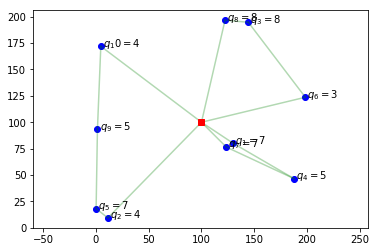

In [17]:
plt.scatter(loc_x[1:], loc_y[1:], c='b')
for i in N:
    plt.annotate('$q_%d=%d$' % (i, q[i]), (loc_x[i]+2, loc_y[i]))
for i, j in active_edges:
    plt.plot([loc_x[i], loc_x[j]], [loc_y[i], loc_y[j]], c='g', alpha=0.3)
plt.plot(loc_x[0], loc_y[0], c='r', marker='s')
plt.axis('equal');